In [1]:
pip install fuzzywuzzy

Note: you may need to restart the kernel to use updated packages.


In [16]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import pickle
import hickle as hkl
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from fuzzywuzzy import fuzz

In [20]:
# Reading all the csv files using pandas
sample = pd.read_csv("sample_submission.csv").drop(sample.index[90000:])
test = pd.read_csv("test.csv").drop(test.index[90000:])
train = pd.read_csv("train.csv").drop(train.index[90000:])

In [22]:
# train = train.drop(train.index[1:3])
train

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
89995,89995,17545,3133,How do I prepare for UGC NET English?,What are the name of the books for UGC net Eng...,1
89996,89996,151091,151092,What are the best arguments for and against th...,What are the best arguments for and against th...,1
89997,89997,151093,151094,Is “love your neighbor” a “religious” concept?,Do you love your neighbor as yourself?,0
89998,89998,151095,151096,How does losing virginity feel?,How did you feel while losing virginity?,0


In [23]:
train.shape

(90000, 6)

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90000 entries, 0 to 89999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            90000 non-null  int64 
 1   qid1          90000 non-null  int64 
 2   qid2          90000 non-null  int64 
 3   question1     90000 non-null  object
 4   question2     90000 non-null  object
 5   is_duplicate  90000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 4.8+ MB


In [25]:
train.groupby("is_duplicate").count()

,id,qid1,qid2,question1,question2
is_duplicate,,,,,
0,56508,56508,56508,56508,56508
1,33492,33492,33492,33492,33492


<AxesSubplot:xlabel='is_duplicate'>

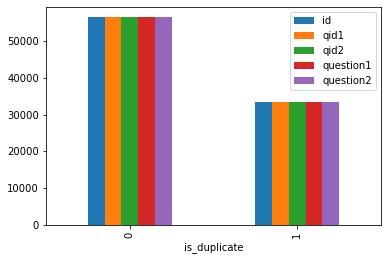

In [26]:
train.groupby("is_duplicate").count().plot.bar()

In [27]:
# Total number of question pairs
print('Total number of question pairs for training =',len(train))

Total number of question pairs for training = 90000


In [28]:
# Similar questions 
print("Question pairs are not Similar =",100-round(sum(train['is_duplicate'])*100/len(train['is_duplicate']),2),'%')
# Not Similar questions 
print("Question pairs are Similar =",round(sum(train['is_duplicate'])*100/len(train['is_duplicate']),2),'%')

Question pairs are not Similar = 62.79 %
Question pairs are Similar = 37.21 %


In [29]:
unique_ques = {}
for i in train['qid1']:
    if i not in unique_ques:
        unique_ques[i]=1
    else:
        unique_ques[i]+=1
for i in train['qid2']:
    if i not in unique_ques:
        unique_ques[i]=1
    else:
        unique_ques[i]+=1
        
ques_repeated = [i for i in unique_ques if unique_ques[i] > 1]
print("unique questions that are repeated =", len(ques_repeated),end=' ')
print('(',len(ques_repeated)*100/len(unique_ques),'% )')

print('Max number of times a single question is repeated =',max([unique_ques[i] for i in unique_ques]))

unique_ques1 = [i for i in unique_ques]
print("Unique Questions are =",len(unique_ques1))


unique questions that are repeated = 16847 ( 11.149717401951051 % )
Max number of times a single question is repeated = 30
Unique Questions are = 151098


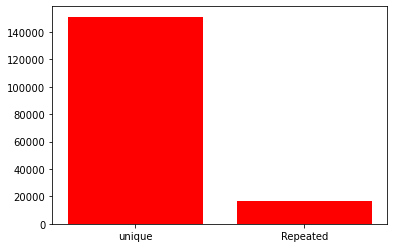

In [30]:
data = {'unique': len(unique_ques1), 'Repeated': len(ques_repeated)}
plt.bar(range(len(data)), list(data.values()), tick_label=list(data.keys()),color='red')
plt.show()

In [31]:
# Check for null values
train[train.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate


In [32]:
# fill null values with empty string
train = train.fillna('')
train

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
89995,89995,17545,3133,How do I prepare for UGC NET English?,What are the name of the books for UGC net Eng...,1
89996,89996,151091,151092,What are the best arguments for and against th...,What are the best arguments for and against th...,1
89997,89997,151093,151094,Is “love your neighbor” a “religious” concept?,Do you love your neighbor as yourself?,0
89998,89998,151095,151096,How does losing virginity feel?,How did you feel while losing virginity?,0


In [33]:
train['question1'][89995]

'How do I prepare for UGC NET English?'

In [34]:
 train['question2'][6157]

'What is the list of legit wholesale suppliers of the Apple iPhone 6s worldwide who accept payments through WU?'

In [35]:
train['question2'][89995]

'What are the name of the books for UGC net English literature?'

In [36]:
train.iloc[89995,:]

id                                                          89995
qid1                                                        17545
qid2                                                         3133
question1                   How do I prepare for UGC NET English?
question2       What are the name of the books for UGC net Eng...
is_duplicate                                                    1
Name: 89995, dtype: object

In [37]:
train[train.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate


In [38]:
def transformer(s1,s2):
    return train.groupby(s1)[s1].transform(s2) 

def strlen(s):
    return train[s].str.len()

# normalized_word_Common
def nwc(row):   
    return 1.0 * len(set(map(lambda word: word.lower().strip(), row['question1'].split(" "))) & set(map(lambda word: word.lower().strip(), row['question2'].split(" "))))

# normalized_word_Total
def nwt(row):   
    return 1.0 * (len(set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))) + len(set(map(lambda word: word.lower().strip(), row['question2'].split(" "))) ))

# normalized_word_share
def nws(row):  
    return 1.0 * len(set(map(lambda word: word.lower().strip(), row['question1'].split(" "))) & set(map(lambda word: word.lower().strip(), row['question2'].split(" "))) )/(len(set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))) + len(set(map(lambda word: word.lower().strip(), row['question2'].split(" "))) ))


# for i in range(1,3):
#     train['freq_qid'+str(i)] = transformer('qid'+str(i),'count')
    
for i in range(1,3):
    train['q'+str(i)+'len'] = strlen('question'+str(i))
  
for i in range(1,3):
    train['q'+str(i)+'_n_words'] = train['question'+str(i)].apply(lambda row: len(row.split(" ")))

train['wc'] = train.apply(nwc, axis=1)
train['wt'] = train.apply(nwt, axis=1)
train['ws'] = train.apply(nws, axis=1)

# train['freq_sum'] = train['freq_qid1']+train['freq_qid2']
# train['freq_diff'] = abs(train['freq_qid1']-train['freq_qid2'])

train.head()


,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,wc,wt,ws
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,10.0,23.0,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,4.0,20.0,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,4.0,24.0,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0.0,19.0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,2.0,20.0,0.100000


In [40]:
def ef(df):
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    return df

ef(train)
train

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,wc,wt,ws,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,10.0,23.0,0.434783,100,93,93,98
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,4.0,20.0,0.200000,86,63,66,73
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,4.0,24.0,0.166667,63,63,43,41
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0.0,19.0,0.000000,28,24,9,20
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,2.0,20.0,0.100000,67,47,35,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,89995,17545,3133,How do I prepare for UGC NET English?,What are the name of the books for UGC net Eng...,1,37,62,8,12,3.0,19.0,0.157895,69,54,52,54
89996,89996,151091,151092,What are the best arguments for and against th...,What are the best arguments for and against th...,1,65,82,12,16,10.0,23.0,0.434783,100,88,88,94
89997,89997,151093,151094,Is “love your neighbor” a “religious” concept?,Do you love your neighbor as yourself?,0,46,38,7,7,1.0,14.0,0.071429,65,64,61,66
89998,89998,151095,151096,How does losing virginity feel?,How did you feel while losing virginity?,0,31,40,5,7,2.0,12.0,0.166667,91,78,70,70


In [41]:
for i in range(1,3):
    print('min length of ques in question',i,'=',min(train['q'+str(i)+'_n_words']))

for i in range(1,3):
    print ("No. of ques with min length (question" +str(i)+ ") :", train[train['q'+str(i)+'_n_words']== 1].shape[0])


min length of ques in question 1 = 1
min length of ques in question 2 = 1
No. of ques with min length (question1) : 14
No. of ques with min length (question2) : 5


In [42]:
y = train.iloc[:,5]
X = train.iloc[:,6:]
X 

,q1len,q2len,q1_n_words,q2_n_words,wc,wt,ws,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,66,57,14,12,10.0,23.0,0.434783,100,93,93,98
1,51,88,8,13,4.0,20.0,0.200000,86,63,66,73
2,73,59,14,10,4.0,24.0,0.166667,63,63,43,41
3,50,65,11,9,0.0,19.0,0.000000,28,24,9,20
4,76,39,13,7,2.0,20.0,0.100000,67,47,35,54
...,...,...,...,...,...,...,...,...,...,...,...
89995,37,62,8,12,3.0,19.0,0.157895,69,54,52,54
89996,65,82,12,16,10.0,23.0,0.434783,100,88,88,94
89997,46,38,7,7,1.0,14.0,0.071429,65,64,61,66
89998,31,40,5,7,2.0,12.0,0.166667,91,78,70,70


In [43]:
X.iloc[6157,:]

q1len                 118.000000
q2len                 110.000000
q1_n_words             20.000000
q2_n_words             19.000000
wc                     15.000000
wt                     35.000000
ws                      0.428571
token_set_ratio        97.000000
token_sort_ratio       93.000000
fuzz_ratio             95.000000
fuzz_partial_ratio     96.000000
Name: 6157, dtype: float64

In [44]:
X.shape

(90000, 11)

In [45]:
y.shape

(90000,)

# Training models

In [46]:
# Splitting the data into train and test datas
'''
We set train_size as 0.75 and random state as 1, 
which implies our test data size is 25 percent 
(including X_test and y_test) of the whole training 
data and the remaining 75 percent data 
(including X_train and y_train) is used to train the model. 

'''
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.75, random_state=1,stratify=y)

# Model-1 RF

In [47]:
# Random Forest
model1 = RandomForestClassifier(n_estimators=500,random_state=1)
model1.fit(X, y)

RandomForestClassifier(n_estimators=500, random_state=1)

In [83]:
# Testing the score of our model
score = model1.score(X_test, y_test)
score

0.9986666666666667

In [84]:
# Analysis of model
print("Test points =",X_test.shape[0])
print("Number of Correct predictions =",int(X_test.shape[0]*score),'('+ str(score*100) +' %)')

Test points = 22500
Number of Correct predictions = 22470 (99.86666666666667 %)


In [85]:
# Predicting values with our model
y_pred = model1.predict(X_test) 
y_pred

array([1, 1, 0, ..., 0, 0, 1], dtype=int64)

In [86]:
y_test

11309    1
5395     1
1011     0
47174    1
46783    1
        ..
82651    1
28566    1
70464    0
24191    0
6157     1
Name: is_duplicate, Length: 22500, dtype: int64

In [87]:
# some analysis of the model
def analysis(y_test, y_pred):
    # confusion matrix
    confusion = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix\n')
    print(confusion)

    # accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

    print('\nClassification Report\n')
    print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2']))

analysis(y_test, y_pred)

Confusion Matrix

[[14107    20]
 [   10  8363]]

Accuracy: 1.00

Micro Precision: 1.00
Micro Recall: 1.00
Micro F1-score: 1.00

Macro Precision: 1.00
Macro Recall: 1.00
Macro F1-score: 1.00

Weighted Precision: 1.00
Weighted Recall: 1.00
Weighted F1-score: 1.00

Classification Report

              precision    recall  f1-score   support

     Class 1       1.00      1.00      1.00     14127
     Class 2       1.00      1.00      1.00      8373

    accuracy                           1.00     22500
   macro avg       1.00      1.00      1.00     22500
weighted avg       1.00      1.00      1.00     22500



In [88]:
# Designing and Testing part
def copied_test_fun(train):
    def transformer(s1,s2):
        return train.groupby(s1)[s1].transform(s2) 

    def strlen(s):
        return train[s].str.len()

    # normalized_word_Common
    def nwc(row):   
        return 1.0 * len(set(map(lambda word: word.lower().strip(), row['question1'].split(" "))) & set(map(lambda word: word.lower().strip(), row['question2'].split(" "))))

    # normalized_word_Total
    def nwt(row):   
        return 1.0 * (len(set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))) + len(set(map(lambda word: word.lower().strip(), row['question2'].split(" "))) ))

    # normalized_word_share
    def nws(row):  
        return 1.0 * len(set(map(lambda word: word.lower().strip(), row['question1'].split(" "))) & set(map(lambda word: word.lower().strip(), row['question2'].split(" "))) )/(len(set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))) + len(set(map(lambda word: word.lower().strip(), row['question2'].split(" "))) ))

    for i in range(1,3):
        train['q'+str(i)+'len'] = strlen('question'+str(i))

    for i in range(1,3):
        train['q'+str(i)+'_n_words'] = train['question'+str(i)].apply(lambda row: len(row.split(" ")))

    train['wc'] = train.apply(nwc, axis=1)
    train['wt'] = train.apply(nwt, axis=1)
    train['ws'] = train.apply(nws, axis=1)
    
    train["token_set_ratio"]       = train.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    train["token_sort_ratio"]      = train.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    train["fuzz_ratio"]            = train.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    train["fuzz_partial_ratio"]    = train.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)


    
q1 = 'What is the list of legit wholesale suppliers of the Apple iPhone 6 Plus worldwide who accept payments through PayPal?'
q2 = 'What is the list of legit wholesale suppliers of the Apple iPhone 6s worldwide who accept payments through WU?'
q1 = 'How do I prepare for UGC NET English?'
q2 = 'What are the name of the books for UGC net English literature?'
# q1 = 'I am apple'
# q2 = 'I am green apple'
q1 = 'How to change a tyre?'
q2 = 'How to drive a car?'

df = {'id':0,'qid1': [1],'qid2': [1],'question1': [q1],'question2': [q2]}
df = pd.DataFrame.from_dict(df, orient='columns')

copied_test_fun(df)
df

,id,qid1,qid2,question1,question2,q1len,q2len,q1_n_words,q2_n_words,wc,wt,ws,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,0,1,1,How to change a tyre?,How to drive a car?,21,19,5,5,3.0,10.0,0.3,63,63,63,63


In [89]:
Xt = df.iloc[:,5:]
Xt
# Xt.shape

,q1len,q2len,q1_n_words,q2_n_words,wc,wt,ws,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,21,19,5,5,3.0,10.0,0.3,63,63,63,63


In [90]:
yt_pred = model1.predict(Xt)
yt_pred

array([1], dtype=int64)